In [2]:
import numpy as np
import pandas as pd
import anndata
import os
import scanpy as sc
import scvelo as scv
import matplotlib

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook with visualization of subsampled reads velocity dataframe

Input dataframe created from running 'evaluate_velocity_df.py,' comparing the velocity prediction from each subset of reads with the prediction from 100% of the reads

In [4]:
big_deep = pd.read_csv('/home/sarah.ancheta/bruno1/projects/data.science/sarah.ancheta/ZF_atlas/rna_velocity/benchmark/velocity_subsets_zf24hpf/cosim_mag_csvs/true_cosim_mag_scv-deepvelo_May30.csv')
big_velocyto = pd.read_csv('/home/sarah.ancheta/bruno1/projects/data.science/sarah.ancheta/ZF_atlas/rna_velocity/benchmark/velocity_subsets_zf24hpf/cosim_mag_csvs/true_cosim_mag_scv-deterministic_May30.csv')
big_dyn = pd.read_csv('/home/sarah.ancheta/bruno1/projects/data.science/sarah.ancheta/ZF_atlas/rna_velocity/benchmark/velocity_subsets_zf24hpf/cosim_mag_csvs/true_cosim_mag_scv-dynamical_May30.csv')
big_sto = pd.read_csv('/home/sarah.ancheta/bruno1/projects/data.science/sarah.ancheta/ZF_atlas/rna_velocity/benchmark/velocity_subsets_zf24hpf/cosim_mag_csvs/true_cosim_mag_scv-stochastic_May30.csv')
big_unit = pd.read_csv('/home/sarah.ancheta/bruno1/projects/data.science/sarah.ancheta/ZF_atlas/rna_velocity/benchmark/velocity_subsets_zf24hpf/cosim_mag_csvs/true_cosim_mag_uniTvelo_May30.csv')

In [5]:
bigDF = pd.concat([big_deep, big_velocyto, big_dyn, big_sto, big_unit])

In [7]:
print(bigDF.proportion.unique())
bigDF.head(5)

[0.25  1.    0.02  0.01  0.98  0.05  0.8   0.12  0.5   0.005 0.9   0.95 ]


,Unnamed: 0,cell_id,mag_velo,mag_trans,cosine_sim,proportion,iteration,velo_method
0,0,TDR43_AAACCCAAGGATATGT-1,10.729276,0.099426,0.609130,0.25,2,deepvelo
1,1,TDR43_AAACCCAAGTCAGCCC-1,13.089113,0.186451,0.101395,0.25,2,deepvelo
2,2,TDR43_AAACCCAGTCTTGGTA-1,24.479760,0.110448,0.255215,0.25,2,deepvelo
3,3,TDR43_AAACCCAGTTTGTGGT-1,43.994526,0.203409,0.221114,0.25,2,deepvelo
4,4,TDR43_AAACGAAAGCTATCCA-1,14.961237,0.137870,0.543994,0.25,2,deepvelo


## Cleaning and creating metrics from dataframe for visualization

In [32]:
big_df = bigDF.copy()

# Isolating the reference mag_trans for each velo_method when proportion=1 and iteration=1
reference_df = big_df[(big_df['proportion'] == 1) & (big_df['iteration'] == 1)]
reference_df = reference_df[['cell_id', 'mag_trans', 'velo_method']].set_index(['cell_id', 'velo_method'])

# Join this reference back to the main DataFrame to have the reference mag_trans alongside each row
big_df = big_df.join(reference_df, on=['cell_id', 'velo_method'], rsuffix='_ref')

# Calculate the new metric for each row in the DataFrame
big_df['new_metric'] = (1 - (big_df['mag_trans_ref'] - big_df['mag_trans']).abs()) * big_df['cosine_sim']

big_df['real_min_max_metric'] = ((np.minimum(big_df['mag_trans_ref'], big_df['mag_trans']))/ (np.maximum(big_df['mag_trans_ref'], big_df['mag_trans']))) * big_df['cosine_sim']


big_df['max_vec_metric'] = np.maximum(big_df['mag_trans'], big_df['mag_trans_ref']) * big_df['cosine_sim']

In [37]:
replacement_dict = {
    'deepvelo': 'DeepVelo',
    'scvelo-deterministic': 'Velocyto',
    'scvelo-stochastic': 'scv-Sto',
    'scvelo-dynamical': 'scv-Dyn',
    'uniTvelo': 'UniTVelo'
}

# Replace values in the 'Method' column
big_df['velo_method'] = big_df['velo_method'].replace(replacement_dict)

In [38]:
big_df_clean = big_df[(big_df['proportion'] >= 0.02) & (big_df['proportion'] != 0.9)]
big_df_clean.groupby(['velo_method'])['proportion'].unique()

velo_method
DeepVelo    [0.25, 1.0, 0.02, 0.98, 0.05, 0.8, 0.12, 0.5, ...
UniTVelo    [0.25, 0.95, 0.12, 0.02, 0.5, 0.05, 0.98, 0.8,...
Velocyto    [0.12, 0.5, 0.25, 0.8, 0.02, 0.05, 0.98, 0.95,...
scv-Dyn     [0.5, 0.98, 0.12, 0.25, 0.8, 1.0, 0.02, 0.95, ...
scv-Sto     [0.98, 1.0, 0.25, 0.05, 0.02, 0.95, 0.5, 0.12,...
Name: proportion, dtype: object

# Make plots comparing the magnitude and cosine similarity of the direction

In [163]:
save_path='/home/sarah.ancheta/bruno1/projects/data.science/sarah.ancheta/ZF_atlas/rna_velocity/benchmark/figures/subset_bam/'

In [35]:
methods_palette = {'DeepVelo': '#0072B5', 
                   
                'scv-Dyn': '#E18727', 
                   'Velocyto': '#00966C',
                  'scv-Sto':'#CF5073',
                  'UniTVelo': '#4D4398'}

In [47]:
big_df_clean.head(3)

,Unnamed: 0,cell_id,mag_velo,mag_trans,cosine_sim,proportion,iteration,velo_method,mag_trans_ref,new_metric,real_min_max_metric,max_vec_metric
0,0,TDR43_AAACCCAAGGATATGT-1,10.729276,0.099426,0.609130,0.25,2,DeepVelo,0.118947,0.597239,0.509162,0.072454
1,1,TDR43_AAACCCAAGTCAGCCC-1,13.089113,0.186451,0.101395,0.25,2,DeepVelo,0.730175,0.046264,0.025891,0.074036
2,2,TDR43_AAACCCAGTCTTGGTA-1,24.479760,0.110448,0.255215,0.25,2,DeepVelo,0.161649,0.242148,0.174377,0.041255


Input the desired column to portray in the lineplot vs. proportion (i.e. cosine_sim, real_min_max_metric)

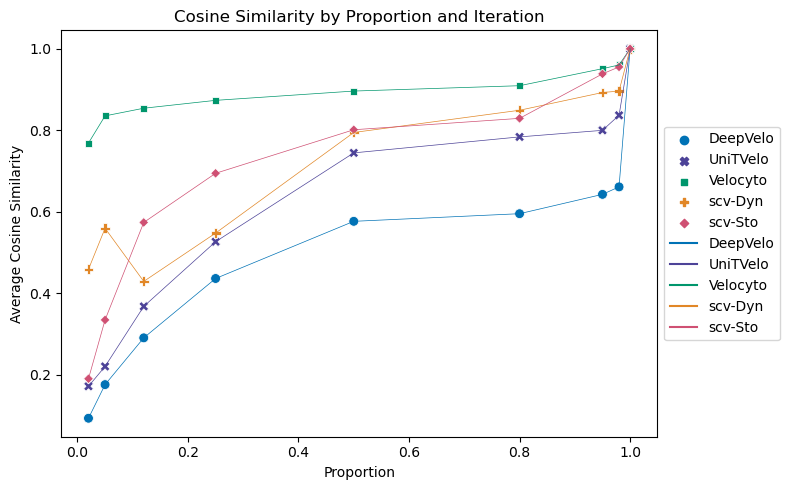

In [39]:
column='cosine_sim'
save_title='min_max_metric_Jun4.svg'
saveFIG=False
saveSVG=False
mytitle='Cosine Similarity by Proportion and Iteration'
my_y='Average Cosine Similarity'

grouped = big_df_clean[(big_df_clean['proportion'] != 0.9)].groupby(['proportion', 'velo_method'])[column].mean().reset_index()

# Now let's plot this using seaborn for a clear and informative visualization
plt.figure(figsize=(8, 6))

# Create a scatter plot with a hue based on 'iteration'
# This makes it easier to distinguish between different iterations at the same proportion
sns.scatterplot(data=grouped, palette=methods_palette, x='proportion', y=column, hue='velo_method', style='velo_method', s=50)
sns.lineplot(data=grouped, palette=methods_palette,x='proportion', y=column, hue='velo_method', style='velo_method', markers=False, dashes=False, linewidth=0.5)


# Adding a title and labels for clarity
plt.title(mytitle)
plt.xlabel('Proportion')
plt.ylabel(my_y)

# Show legend and plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.grid(False)

plt.gcf().set_size_inches(8, 5)

plt.tight_layout()
if saveFIG:
    plt.savefig(save_path+save_title, dpi=500)
    
if saveSVG:
    plt.savefig(save_path+save_title)
else:
    None

plt.show()

Plot the IQR (25%-75%) with the median cosine similarity

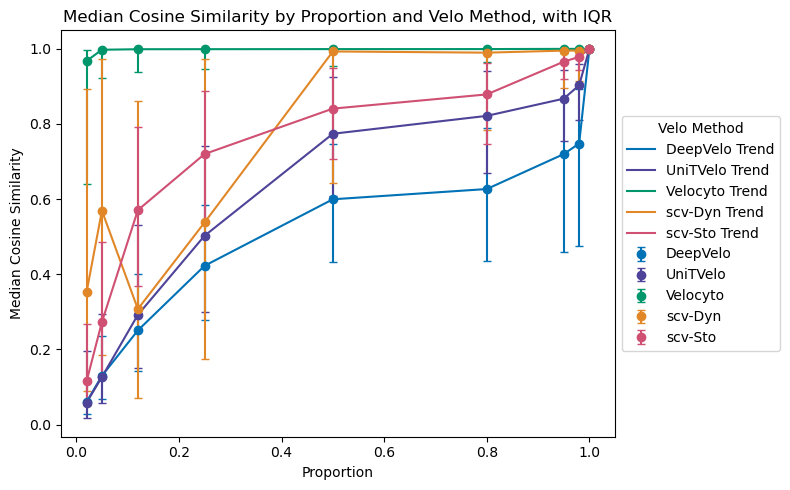

In [46]:
save=False
save_title='with_scvDyn_iqr_cosine_sim.svg'
# Assuming 'big_df' is your DataFrame and it's already loaded
grouped = big_df_clean[(big_df_clean['proportion'] != 0.9)].groupby(['proportion', 'velo_method'])['cosine_sim'].agg(
    median=np.median,
    q25=lambda x: np.percentile(x, 25),
    q75=lambda x: np.percentile(x, 75)
).reset_index()

plt.figure(figsize=(10, 6))

# Use the custom palette to maintain color consistency across plots
color_map = {method: methods_palette[method] for method in grouped['velo_method'].unique()}

# Plot error bars for each group
for _, row in grouped.iterrows():
    # Calculate error bars for the interquartile range
    err_lower = row['median'] - row['q25']
    err_upper = row['q75'] - row['median']
    plt.errorbar(x=row['proportion'], y=row['median'], yerr=[[err_lower], [err_upper]], fmt='o',
                 color=color_map[row['velo_method']], capsize=3, label=row['velo_method'])

# Plot lines connecting the median values for each velo_method
for method, group in grouped.groupby('velo_method'):
    plt.plot(group['proportion'], group['median'], color=color_map[method], label=f"{method} Trend")

# Adding a title and labels for clarity
plt.title('Median Cosine Similarity by Proportion and Velo Method, with IQR')
plt.xlabel('Proportion')
plt.ylabel('Median Cosine Similarity')

# Show legend and plot
# Handle duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels

# Show legend and plot
plt.legend(by_label.values(), by_label.keys(), title='Velo Method',loc='center left', bbox_to_anchor=(1, 0.5))


plt.grid(False)

plt.gcf().set_size_inches(8, 5)

plt.tight_layout()
if save:
    plt.savefig(save_path+save_title)
else:
    None
plt.show()


Plot the distribution of the magnitude vs. the proportion as a boxplot

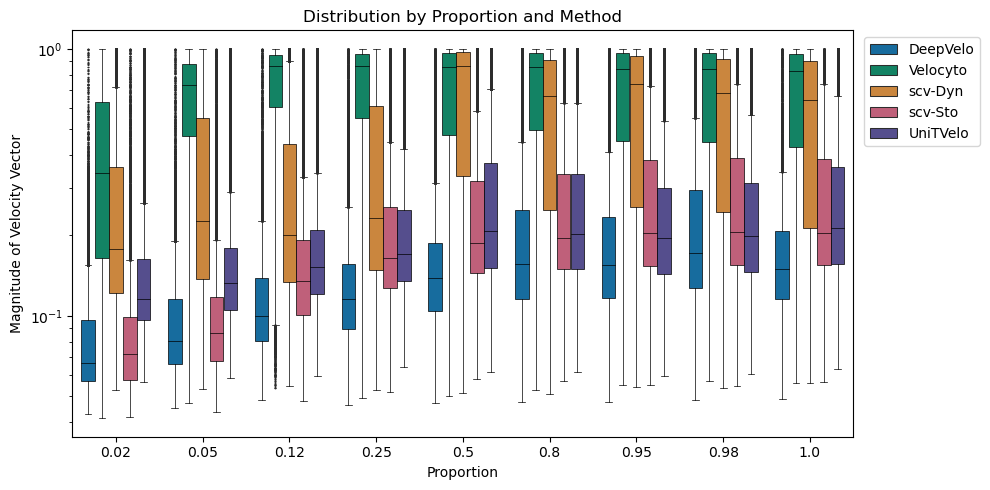

In [41]:
# Create the box plot
save=False
y_label = 'Magnitude of Velocity Vector'
column='mag_trans'
save_title='magnitude_velovector_boxplot_distribution_Jun11.svg'

plt.figure(figsize=(10, 6))  # You can adjust the size to fit your needs
ax = sns.boxplot(data=big_df_clean, x='proportion', y=column, hue='velo_method', palette = methods_palette, 
            
                boxprops=dict(edgecolor="black", linewidth=0.5),
                 whiskerprops=dict(color="black", linewidth=0.5),
                 capprops=dict(color="black", linewidth=0.5),
                 medianprops=dict(color="black", linewidth=0.5), 
                 flierprops = dict(markerfacecolor='black', markersize=0.3,
                                   linestyle='none'),)

for child in ax.get_children():
    if isinstance(child, (matplotlib.patches.PathPatch, matplotlib.lines.Line2D)):
        child.set_rasterized(True)  # Rasterizing boxes, whiskers, caps, fliers


# Adding labels and title for clarity
plt.title('Distribution by Proportion and Method')
plt.xlabel('Proportion')
plt.ylabel(y_label)
plt.yscale('log')

# Show the plot

plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left')
plt.gcf().set_size_inches(10, 5)

plt.tight_layout()
        
if save:
    plt.savefig(save_path+save_title, dpi=500)
else:
    None

plt.show()

Plot the magnitude of 100% of the reads vs. a subset of the reads, for a velocity method.

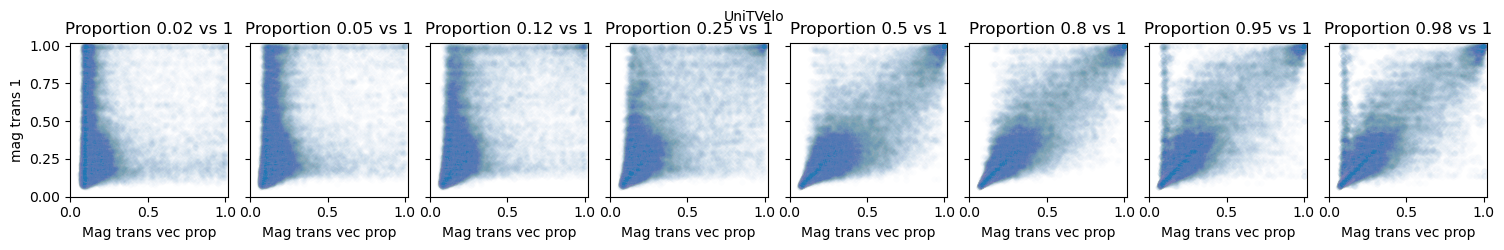

In [43]:
save=False
mymethod = 'UniTVelo'
save_title='jun7_unitvelo_compare_mag.png'

test_df = big_df_clean[big_df_clean['velo_method'] == mymethod]

# Assuming df is your DataFrame loaded with data
# Example DataFrame loading (replace this with actual data loading if necessary)
# df = pd.read_csv('path_to_your_data.csv')

# Identify all unique proportions except 1
unique_proportions = test_df['proportion'].unique()
unique_proportions = [p for p in unique_proportions if p != 1]

# Ensure the proportions are sorted
unique_proportions.sort()

# Filter data for proportion 1
df_1 = test_df[test_df['proportion'] == 1]

# Setup the plot grid
n_cols = len(unique_proportions)
fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5), sharex=True, sharey=True)

# Loop through each unique proportion and create a subplot
for i, prop in enumerate(unique_proportions):
    df_prop = test_df[test_df['proportion'] == prop]
    merged_df = pd.merge(df_prop, df_1, on='cell_id', suffixes=(f'_{prop}', '_1'))
    
    ax = axes[i]
    ax.scatter(merged_df[f'mag_trans_{prop}'], merged_df['mag_trans_1'], alpha=0.01, edgecolors='w', s=20)
    ax.set_title(f'Proportion {prop} vs 1')
    ax.set_xlabel(f'Mag trans vec prop')
    ax.set_xlim(0, 1.02)
    ax.set_ylim(0, 1.02)

# Set common labels
axes[0].set_ylabel('mag trans 1')

fig.suptitle(mymethod, fontsize=10)

plt.gcf().set_size_inches(15, 2.5)

# Adjust layout to make room for the main title
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top spacing to fit the suptitle

if save:
    plt.savefig(save_path+save_title, dpi=500)
else:
    None

plt.show()



Plot the average cosine similarity separated by iteration, for a single method.

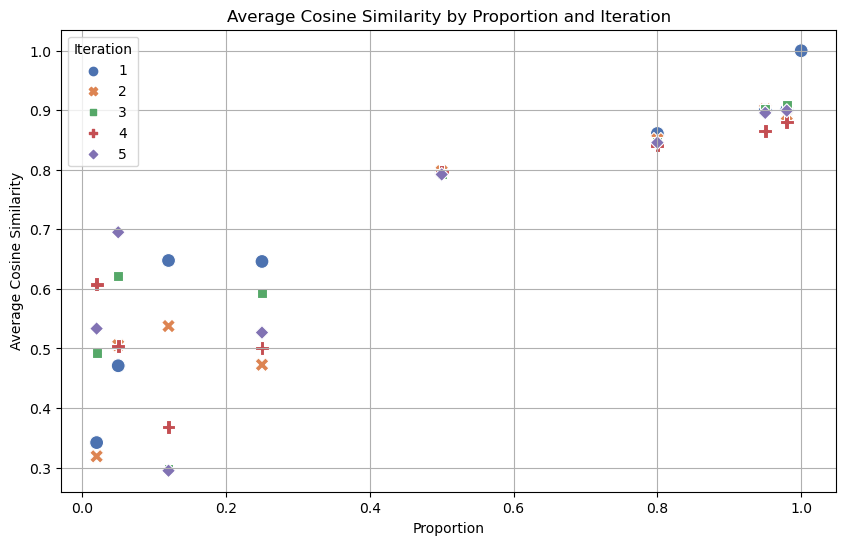

In [44]:
grouped = big_df_clean[big_df_clean['velo_method'] == 'scv-Dyn'].groupby(['proportion', 'iteration'])['cosine_sim'].mean().reset_index()

# Now let's plot this using seaborn for a clear and informative visualization
plt.figure(figsize=(10, 6))

# Create a scatter plot with a hue based on 'iteration'
# This makes it easier to distinguish between different iterations at the same proportion
sns.scatterplot(data=grouped, x='proportion', y='cosine_sim', hue='iteration', style='iteration', palette='deep', s=100)

# Adding a title and labels for clarity
plt.title('Average Cosine Similarity by Proportion and Iteration')
plt.xlabel('Proportion')
plt.ylabel('Average Cosine Similarity')

# Show legend and plot
plt.legend(title='Iteration')
plt.grid(True)
plt.show()